In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import depthai
from tqdm import tqdm

In [8]:
def record_video(path):
    pipeline = depthai.Pipeline()
    cam_rgb = pipeline.create(depthai.node.ColorCamera)
    cam_rgb.setPreviewSize(1280,720)
    cam_rgb.setInterleaved(False)
    xout_rgb = pipeline.create(depthai.node.XLinkOut)
    xout_rgb.setStreamName("rgb")
    cam_rgb.preview.link(xout_rgb.input)
    vid_cod = cv2.VideoWriter_fourcc(*'XVID')
    output = cv2.VideoWriter(path, vid_cod, 20.0, (1280, 720))
    with depthai.Device(pipeline) as device:
        q_rgb = device.getOutputQueue(name="rgb", maxSize=4, blocking=False)
        while True:
            in_rgb = q_rgb.tryGet()

            if in_rgb is not None:
                shape = (3, in_rgb.getHeight(), in_rgb.getWidth())
                frame = in_rgb.getData().reshape(shape).transpose(1, 2, 0).astype(np.uint8)
                frame = np.ascontiguousarray(frame)
                cv2.imshow("rgb", frame)
                output.write(frame)
            if cv2.waitKey(1) == ord('q'):
                break
        
    output.release()
    cv2.destroyAllWindows()
            

In [9]:
record_video("videos/motion_video.mp4")

In [14]:
def show_video(path):
    vid = cv2.VideoCapture(path)
    while True:
        ret, frame = vid.read()
        if ret:
            frame = cv2.resize(frame, (1280, 720))
            cv2.imshow("frame", frame)
            if cv2.waitKey(1) == ord('q'):
                break
        else:
            break
    cv2.destroyAllWindows()

show_video("videos/motion_video.mp4")

In [46]:
def get_frames(path, wanted_frames):
    vid = cv2.VideoCapture(path)
    frames = []
    for i in wanted_frames:
        vid.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = vid.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    return frames

num_of_frames = cv2.VideoCapture("videos/motion_video.mp4").get(cv2.CAP_PROP_FRAME_COUNT)
random_frame = np.random.randint(0, num_of_frames-1)
frames = get_frames("videos/motion_video.mp4", [random_frame,random_frame+1])

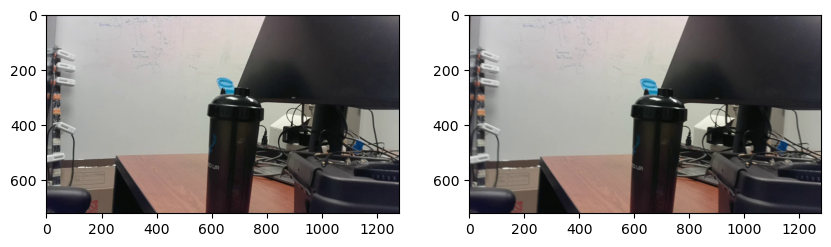

In [47]:
# show the frames
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(frames[0])
ax[1].imshow(frames[1])


In [48]:
def motion_constraints(Iref, Inext):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    Iref = Iref / 255. # normalize pixels
    Inext = Inext / 255. # normalize pixels
    mode = 'same'
    Ix = signal.convolve2d(Iref, kernel_x, boundary='symm', mode=mode)
    Iy = signal.convolve2d(Iref, kernel_y, boundary='symm', mode=mode)
    It = signal.convolve2d(Inext, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(Iref, -kernel_t, boundary='symm', mode=mode)
    return Ix, Iy, It

In [49]:
I_ref = cv2.cvtColor(frames[0], cv2.COLOR_RGB2GRAY)
I_next = cv2.cvtColor(frames[1], cv2.COLOR_RGB2GRAY)

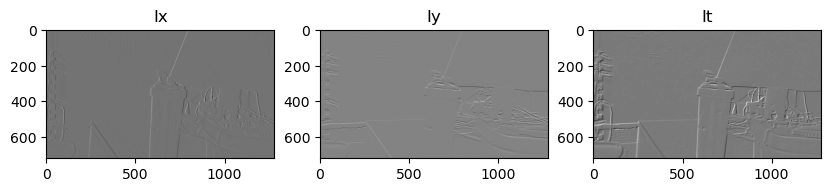

Optical Flow: 100%|██████████| 718/718 [00:56<00:00, 12.81it/s]


In [51]:
def lucas_kanade(Iref, Inext, window_size=3, tau=0.01):
    Ix, Iy, It = motion_constraints(Iref, Inext)

    # Display the motion constraints
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(Ix, cmap='gray')
    plt.title("Ix")
    plt.subplot(1,3,2)
    plt.imshow(Iy, cmap='gray')
    plt.title("Iy")
    plt.subplot(1,3,3)
    plt.imshow(It, cmap='gray')
    plt.title("It")
    plt.show()

    w = window_size//2
    u = np.zeros_like(Iref)
    v = np.zeros_like(Iref)

    for i in tqdm(range(w, Iref.shape[0]-w), desc="Optical Flow"):
        for j in range(w, Iref.shape[1]-w):
            # extract the window
            Ix_window = Ix[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy_window = Iy[i-w:i+w+1, j-w:j+w+1].flatten()
            It_window = It[i-w:i+w+1, j-w:j+w+1].flatten()
            b = -It_window.reshape(It_window.shape[0],1)
            A = np.vstack((Ix_window, Iy_window)).T

            if np.min(np.linalg.eigvals(np.matmul(A.T, A))) > tau:
                nu = np.matmul(np.linalg.pinv(A), b)
                u[i,j] = nu[0]
                v[i,j] = nu[1]
    return (u,v)

u, v = lucas_kanade(I_ref, I_next)



Interpolating: 100%|██████████| 720/720 [00:04<00:00, 144.98it/s]


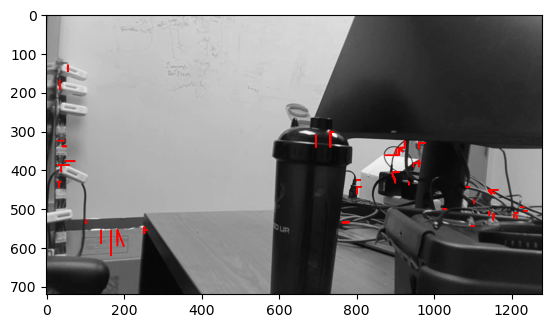

In [53]:
def interpolate_flow(u, v, min=0.1, max=10, multiplier=1):    
    for i in tqdm(range(u.shape[0]), desc="Interpolating"):
        for j in range(u.shape[1]):
            if (abs(u[i,j])>min or abs(v[i,j])>min) and (abs(u[i,j])<max and abs(v[i,j])<max):
                plt.arrow(j,i,v[i,j]*multiplier,u[i,j]*multiplier,head_width = 2, head_length = 2, color = 'r')
    plt.imshow(I_ref, cmap='gray')
    plt.show()

interpolate_flow(u, v, multiplier=8)


In [ ]:
def record_video(path):
    pipeline = depthai.Pipeline()
    cam_rgb = pipeline.create(depthai.node.ColorCamera)
    cam_rgb.setPreviewSize(1280,720)
    cam_rgb.setInterleaved(False)
    xout_rgb = pipeline.create(depthai.node.XLinkOut)
    xout_rgb.setStreamName("rgb")
    cam_rgb.preview.link(xout_rgb.input)
    vid_cod = cv2.VideoWriter_fourcc(*'XVID')
    output = cv2.VideoWriter(path, vid_cod, 20.0, (1280, 720))
    with depthai.Device(pipeline) as device:
        q_rgb = device.getOutputQueue(name="rgb", maxSize=4, blocking=False)
        while True:
            in_rgb = q_rgb.tryGet()

            if in_rgb is not None:
                shape = (3, in_rgb.getHeight(), in_rgb.getWidth())
                frame = in_rgb.getData().reshape(shape).transpose(1, 2, 0).astype(np.uint8)
                frame = np.ascontiguousarray(frame)
                cv2.imshow("rgb", frame)
                output.write(frame)
            if cv2.waitKey(1) == ord('q'):
                break
        
    output.release()
    cv2.destroyAllWindows()
            